## Data needed

- Theory:

> $C_{\ell}$ : theoretical power spectra from CAMB, values at each single $\ell$； (lensing BB + r + $\Lambda CDM$)

> $C_{\ell}^b$ : bandpower for each $\ell$-bin, using $W$indow function.

- Experiment(**Simulation**):

> $W$ : window function for each $\ell$ bin；

> $M$ : band power covariance matrix;

> $N_{\ell}$ : noise;

> $C_{f,l}$ : fiducial power spectra.

- Data

> $\hat {C}_{\ell} $ : observed data.

BB 95 $\times$ 95 150 $\times$ 150 95 $\times$ 150

In [73]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
import pymaster as nmt
import bandpowers
import utils
import camb

import imp
%matplotlib inline

In [14]:
## To generate one realization of noise maps. 
SamNum = 500

In [3]:
nside = 128
nmtlmax = 201
lmin = 2
lmax = 1521

In [6]:
b = nmt.NmtBin(nside, nlb=20, is_Dell=True, lmax=nmtlmax)
leff = b.get_effective_ells()
nbin = len(leff)
b_ind = np.arange(1,nbin+1)

In [9]:
ali_ma = hp.read_map('/fnx/jianyao/Likelihood_data/ABSData/ali_mask.fits', field = None)

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [10]:
est = bandpowers.BPE(mask_in = ali_ma, nside = 128, bin_w = 20, lmax = nmtlmax)

In [11]:
lbin = est.lbin

## Generate Cl_theory; 

In [17]:
def Gencl(r = 0.05, raw_cl = True):
    '''
    Generate the theoretical power spectra using camb
    '''
    
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.26, ombh2=0.022, omch2=0.1199, mnu=0.06, omk=0, tau=0.078)
    pars.InitPower.set_params(As=2.19856*1e-9, ns=0.9652, r = r)
    pars.set_for_lmax(3000, lens_potential_accuracy=1)
    pars.WantTensors = True
    
    results = camb.get_results(pars)
    powers =results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=raw_cl)
    
    totCL=powers['total'] ## TT EE BB TE
#     ell = np.arange(len(totCL.T[0]))
    return totCL.T

In [ ]:
totalcl = Gencl(0.05, raw_cl=False)

In [ ]:
cl_f_i = b.bin_cell(totalcl[2][0:nmtlmax+1])  ## without foreground and noise for now

cl_f = np.ones((lbin, Nf, Nf)); cl_th = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
for ell in range(lbin):
    cl_f[ell] *= cl_f_i[ell]
    cl_th[ell] *= cl_f_i[ell]

## CMB

In [34]:
for i in range(5):
    print('%03d'%i)

000
001
002
003
004


In [36]:
for n in range(SamNum):
    
    cmb_map_i = hp.synfast(Gencl(0.05, raw_cl=False), nside = nside, new = True, verbose = False)
    
    np.save('/fnx/jianyao/Likelihood_data/Simulations/CMB/cmb_maps_mc_%03d.npy'%n, cmb_map_i)

## Noise

> cl_noise_file = AliCPT_noise.dat

39x7 (first line is \ell bin, what remain are cross bandpowers bwtween frequencies)

cl_noise_order = Ali_95_BxAli_95_B Ali_95_BxAli_150_B Ali_95_BxAli_353_B Ali_150_BxAli_150_B Ali_150_BxAli_353_B Ali_353_BxAli_353_B

In [42]:
nvars = ['/fnx/jianyao/Likelihood_data/ABSData/plkvar_30.fits','/fnx/jianyao/Likelihood_data/ABSData/alivar_95.fits',
         '/fnx/jianyao/Likelihood_data/ABSData/alivar_150.fits','/fnx/jianyao/Likelihood_data/ABSData/plkvar_353.fits']

# Nvar = np.concatenate((n1test, n2test, n3test, n4test), axis = 1)

n2test = hp.read_map(nvars[2], field = None, verbose = False)
index = np.arange(len(n2test[0]))#index[n2zeros == 0]
ali_pix = index[n2test[1] != 0]

fres = ['30','95','150','353']
for fre in range(4):
    
    var = np.sqrt(hp.read_map(nvars[fre], field = None, verbose = False))
    
    nIQU = np.zeros((3, 12*nside**2, SamNum))
    
    for i in ali_pix:
        
        nIQU[0][i] = np.random.normal(0, var[0][i], size = SamNum)  #np.random.normal(0, 2.05) ## ignore TT noise for now.
        nIQU[1][i] = np.random.normal(0, var[1][i], size = SamNum)
        nIQU[2][i] = np.random.normal(0, var[2][i], size = SamNum)

    np.save('/fnx/jianyao/Likelihood_data/Simulations/Noises/Noise_realizations_%sGHz.npy'%(fres[fre]), (nIQU.swapaxes(1,2).swapaxes(0,1))) ## (SamNum,3, npix)

## Calculate the correlation between different lbin

In [91]:
est = bandpowers.BPE(mask_in = ali_ma, nside = 128, bin_w = 20, lmax = nmtlmax, wsp = True)

In [ ]:
noise_150 = np.load('/fnx/jianyao/Likelihood_data/Simulations/Noises/Noise_realizations_150GHz.npy')

In [106]:
cls_all = np.zeros((SamNum, 6, lbin))

for n in range(SamNum):
    ''' mark '''
    cmb_i = np.load('/fnx/jianyao/Likelihood_data/Simulations/CMB/cmb_maps_mc_%03d.npy'%n)
    
    total_i = cmb_i + noise_150[n]
    
    cls_all[n] = est.Auto_TEB(total_i)
    
#     cl_hat_all[n] = est.Cross_EB(total_i)## EE EB BB-mode 

In [114]:
cov = np.corrcoef(cls_all[:,5,:].T)

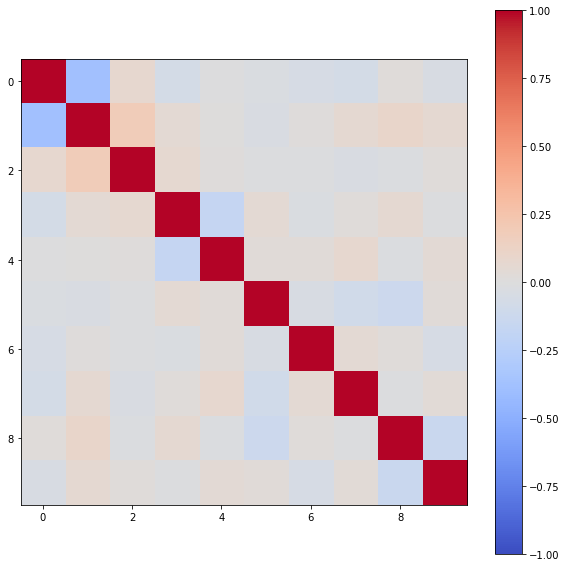

In [115]:
plt.figure(figsize = (10,10))
plt.imshow(cov, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.colorbar()

## Generate M